In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
pd.set_option('use_inf_as_na', True)
from collections import Counter

In [2]:
raw_data = pd.read_pickle(r'/Users/qigege/Desktop/33160 Machine Learning in Finance/Assignment/Assignment1/dataset.pkl')

In [3]:
raw_data = raw_data.drop([x  for x in raw_data.columns if 'fqtr' in x],axis=1)

In [4]:
data = raw_data[raw_data['market_cap'] > 1000.0]

## Question 1

In [5]:
data = data.copy()
data.fillna(0.0,inplace=True)

In [6]:
def f(x):
    if x > 0.05:
        return 1
    elif x < -0.1:
        return -1
    else:
    
        return 0

In [7]:
data['rel_performance'] = data['pred_rel_return'].apply(f)

In [8]:
data.reset_index(inplace=True,)
data.set_index('date',inplace=True)

data.sort_index()
data.head()

df_train = data.loc['2007-01-01':'2010-01-01']

df_valid = data.loc['2010-04-01':'2010-07-01']
df_test = data.loc['2010-07-01':'2010-10-01']

train = df_train.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)


valid = df_valid.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)
test = df_test.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

train_stock_returns = df_train['next_period_return']
valid_stock_returns = df_valid['next_period_return']
test_stock_returns = df_test['next_period_return']

y_train = df_train['rel_performance']
y_valid = df_valid['rel_performance']
y_test = df_test['rel_performance']

y_train = y_train.values
y_valid = y_valid.values
y_test = y_test.values

In [9]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [10]:
scaler = StandardScaler()

In [11]:
float_vars = [x for x in train.columns if data[x].dtype == 'float64']

In [12]:
len(float_vars)

179

In [13]:
train_norm = train.copy()
valid_norm = valid.copy()
test_norm = test.copy()

In [14]:
train_norm[float_vars] = scaler.fit_transform(train[float_vars])
valid_norm[float_vars] = scaler.transform(valid[float_vars])
test_norm[float_vars] = scaler.transform(test[float_vars])

In [15]:
t_clf = DecisionTreeClassifier(max_depth=6,min_samples_leaf=200)

In [16]:
bg_clf = BaggingClassifier(t_clf,n_estimators=40,random_state=123,n_jobs=-1)

In [17]:
bg_clf.fit(train_norm,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=6,
                                                        min_samples_leaf=200),
                  n_estimators=40, n_jobs=-1, random_state=123)

In [18]:
def bagging_feat_importance(m, df):
    feature_importances = []
    for est in m.estimators_:
        fi = est.feature_importances_
        feature_importances.append(fi)
    feature_importances = np.array(feature_importances)
        
    return pd.DataFrame({'cols':train.columns, 'feat_imp':np.mean(feature_importances,axis=0)}
                       ).sort_values('feat_imp', ascending=False)


def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

In [19]:
fi = bagging_feat_importance(bg_clf,train)

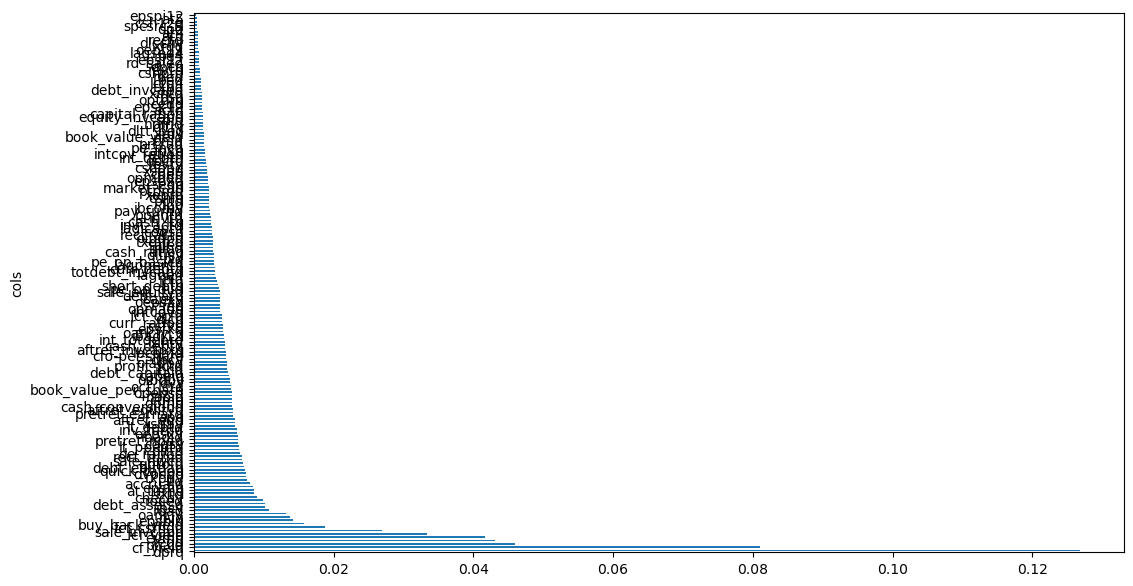

In [20]:
features = fi[(fi['feat_imp'] > 0.0)]
plot_fi(features);

In [21]:
len(features)

160

In [22]:
bg_clf.score(train,y_train)

0.40506958250497016

In [23]:
bg_clf.score(valid,y_valid)

0.4115197779319917

In [24]:
pred_valid = bg_clf.predict(valid_norm)

In [25]:
Counter(pred_valid)

Counter({0: 612, 1: 824, -1: 5})

In [26]:
Counter(y_valid)

Counter({0: 618, 1: 546, -1: 277})

In [27]:
profit = (pred_valid*valid_stock_returns).sum()
profit

-32.22385700000004

In [29]:
import optuna
from optuna.trial import Trial

In [30]:
def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    t_min_samples_leaf = trial.suggest_int('min_samples_leaf',100,1200,step=100)
    t_max_depth = trial.suggest_int('max_depth',5,25,step=5)
    t_n_estimators = trial.suggest_int('n_estimators',5,50,step=5)

    
    t_clf = DecisionTreeClassifier(min_samples_leaf = t_min_samples_leaf,max_depth=t_max_depth,random_state=123)
    bg_clf = BaggingClassifier(t_clf,n_estimators=t_n_estimators,random_state=123,n_jobs=1)
    bg_clf.fit(train,labels)

    preds = bg_clf.predict(val)
    profit = (preds * val_rets).sum()

#     score = bg_clf.score(val,val_labels)

    return profit

In [31]:
study = optuna.create_study(direction="maximize")

[I 2023-01-28 17:22:48,662] A new study created in memory with name: no-name-205ecbe2-745f-4723-88fa-ab05314afc4d


In [32]:
from functools import partial

In [33]:
%%time
study.optimize(partial(objective,train=train_norm,labels=y_train,val=valid_norm,val_labels=y_valid,val_rets=valid_stock_returns.values), n_trials=200,n_jobs=-1)

[I 2023-01-28 17:23:20,113] Trial 1 finished with value: -39.03628400000002 and parameters: {'min_samples_leaf': 1200, 'max_depth': 20, 'n_estimators': 15}. Best is trial 1 with value: -39.03628400000002.
[I 2023-01-28 17:23:24,909] Trial 4 finished with value: -38.22225600000002 and parameters: {'min_samples_leaf': 1200, 'max_depth': 15, 'n_estimators': 20}. Best is trial 4 with value: -38.22225600000002.
[I 2023-01-28 17:23:33,952] Trial 9 finished with value: -38.84531300000005 and parameters: {'min_samples_leaf': 900, 'max_depth': 15, 'n_estimators': 10}. Best is trial 4 with value: -38.22225600000002.
[I 2023-01-28 17:23:35,422] Trial 6 finished with value: -38.16231900000003 and parameters: {'min_samples_leaf': 700, 'max_depth': 10, 'n_estimators': 25}. Best is trial 6 with value: -38.16231900000003.
[I 2023-01-28 17:23:36,909] Trial 2 finished with value: -37.860174000000036 and parameters: {'min_samples_leaf': 600, 'max_depth': 25, 'n_estimators': 25}. Best is trial 2 with valu

[I 2023-01-28 17:24:55,833] Trial 36 finished with value: -33.92330600000005 and parameters: {'min_samples_leaf': 300, 'max_depth': 10, 'n_estimators': 10}. Best is trial 18 with value: -27.05598600000003.
[I 2023-01-28 17:24:57,827] Trial 41 finished with value: -29.97826000000004 and parameters: {'min_samples_leaf': 200, 'max_depth': 5, 'n_estimators': 5}. Best is trial 18 with value: -27.05598600000003.
[I 2023-01-28 17:24:58,747] Trial 17 finished with value: -35.27752700000003 and parameters: {'min_samples_leaf': 200, 'max_depth': 5, 'n_estimators': 50}. Best is trial 18 with value: -27.05598600000003.
[I 2023-01-28 17:25:00,071] Trial 43 finished with value: -29.97826000000004 and parameters: {'min_samples_leaf': 200, 'max_depth': 5, 'n_estimators': 5}. Best is trial 18 with value: -27.05598600000003.
[I 2023-01-28 17:25:00,664] Trial 42 finished with value: -28.683853000000042 and parameters: {'min_samples_leaf': 200, 'max_depth': 10, 'n_estimators': 5}. Best is trial 18 with va

[I 2023-01-28 17:27:11,980] Trial 78 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 25, 'n_estimators': 10}. Best is trial 66 with value: -26.843109000000055.
[I 2023-01-28 17:27:16,769] Trial 72 finished with value: -30.222036000000053 and parameters: {'min_samples_leaf': 100, 'max_depth': 25, 'n_estimators': 45}. Best is trial 66 with value: -26.843109000000055.
[I 2023-01-28 17:27:20,291] Trial 80 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 25, 'n_estimators': 10}. Best is trial 66 with value: -26.843109000000055.
[I 2023-01-28 17:27:21,039] Trial 73 finished with value: -30.222036000000053 and parameters: {'min_samples_leaf': 100, 'max_depth': 25, 'n_estimators': 45}. Best is trial 66 with value: -26.843109000000055.
[I 2023-01-28 17:27:24,646] Trial 82 finished with value: -30.706069000000042 and parameters: {'min_samples_leaf': 200, 'max_depth': 25, 'n_estimators': 15}. Best is tr

[I 2023-01-28 17:28:08,491] Trial 114 finished with value: -26.944043000000054 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 5}. Best is trial 66 with value: -26.843109000000055.
[I 2023-01-28 17:28:09,117] Trial 115 finished with value: -26.944043000000054 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 5}. Best is trial 66 with value: -26.843109000000055.
[I 2023-01-28 17:28:11,651] Trial 116 finished with value: -26.944043000000054 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 5}. Best is trial 66 with value: -26.843109000000055.
[I 2023-01-28 17:28:13,638] Trial 118 finished with value: -26.944043000000054 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 5}. Best is trial 66 with value: -26.843109000000055.
[I 2023-01-28 17:28:21,034] Trial 117 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 10}. Best is t

[I 2023-01-28 17:29:47,601] Trial 150 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 25, 'n_estimators': 10}. Best is trial 66 with value: -26.843109000000055.
[I 2023-01-28 17:29:48,900] Trial 151 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 10}. Best is trial 66 with value: -26.843109000000055.
[I 2023-01-28 17:29:50,251] Trial 152 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 10}. Best is trial 66 with value: -26.843109000000055.
[I 2023-01-28 17:29:52,002] Trial 154 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 10}. Best is trial 66 with value: -26.843109000000055.
[I 2023-01-28 17:29:52,863] Trial 156 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 10}. Best 

[I 2023-01-28 17:31:11,110] Trial 190 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 25, 'n_estimators': 10}. Best is trial 66 with value: -26.843109000000055.
[I 2023-01-28 17:31:16,299] Trial 183 finished with value: -30.761992000000024 and parameters: {'min_samples_leaf': 200, 'max_depth': 25, 'n_estimators': 25}. Best is trial 66 with value: -26.843109000000055.
[I 2023-01-28 17:31:21,048] Trial 192 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 25, 'n_estimators': 10}. Best is trial 66 with value: -26.843109000000055.
[I 2023-01-28 17:31:25,371] Trial 194 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 25, 'n_estimators': 10}. Best is trial 66 with value: -26.843109000000055.
[I 2023-01-28 17:31:29,360] Trial 195 finished with value: -38.706668000000036 and parameters: {'min_samples_leaf': 1000, 'max_depth': 25, 'n_estimators': 25}. Best

CPU times: user 50min 55s, sys: 3min 13s, total: 54min 9s
Wall time: 8min 43s


In [34]:
study.best_params

{'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 10}

In [35]:
t_clf = DecisionTreeClassifier(**{'min_samples_leaf': 500, 'max_depth': 5},random_state=123)
bg_clf = BaggingClassifier(t_clf,n_estimators=5,random_state=123)

In [36]:
bg_clf.fit(train_norm,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                        min_samples_leaf=500,
                                                        random_state=123),
                  n_estimators=5, random_state=123)

In [37]:
pred_valid = bg_clf.predict(valid_norm)

In [38]:
bg_clf.score(train_norm,y_train)

0.45750497017892644

In [39]:
bg_clf.score(valid_norm,y_valid)

0.3816793893129771

In [40]:
confusion_matrix(pred_valid,y_valid)

array([[  0,   0,   0],
       [ 56, 226, 222],
       [221, 392, 324]])

In [41]:
(pred_valid * df_valid['next_period_return'].values).sum()

-37.86556300000003

In [42]:
fi = bagging_feat_importance(bg_clf,train_norm)

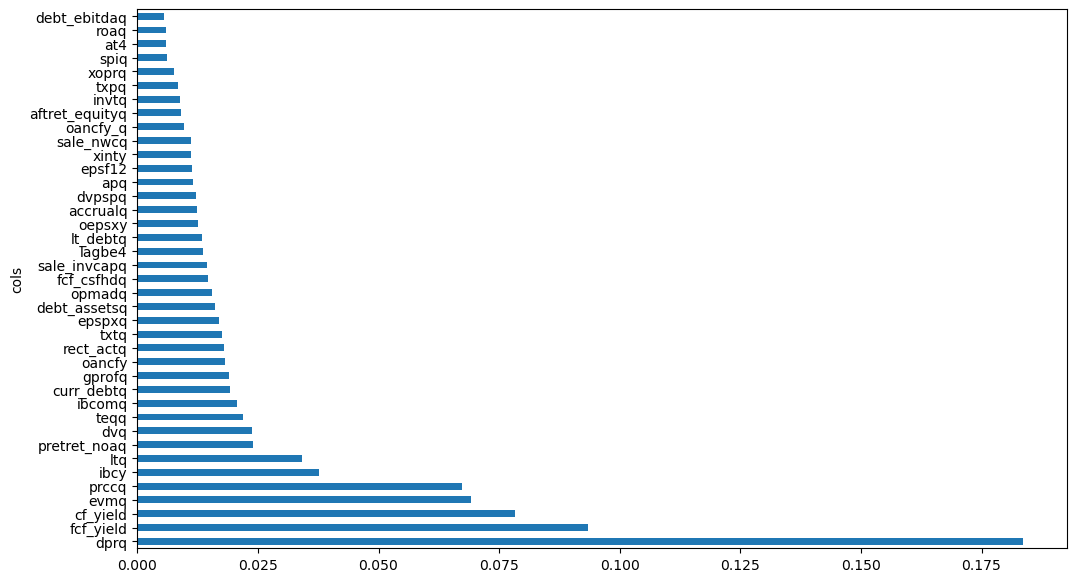

In [80]:
features = fi[(fi['feat_imp'] > 0.0)]
plot_fi(features);

In [81]:
features

,cols,feat_imp
108,dprq,0.183588
156,fcf_yield,0.093496
105,cf_yield,0.078295
95,evmq,0.069242
87,prccq,0.067216
74,ibcy,0.037613
32,ltq,0.034192
134,pretret_noaq,0.023975
107,dvq,0.023843
55,teqq,0.021879


In [82]:
cols = features['cols'].values

In [83]:
cols

array(['dprq', 'fcf_yield', 'cf_yield', 'evmq', 'prccq', 'ibcy', 'ltq',
       'pretret_noaq', 'dvq', 'teqq', 'ibcomq', 'curr_debtq', 'gprofq',
       'oancfy', 'rect_actq', 'txtq', 'epspxq', 'debt_assetsq', 'opmadq',
       'fcf_csfhdq', 'sale_invcapq', 'lagbe4', 'lt_debtq', 'oepsxy',
       'accrualq', 'dvpspq', 'apq', 'epsf12', 'xinty', 'sale_nwcq',
       'oancfy_q', 'aftret_equityq', 'invtq', 'txpq', 'xoprq', 'spiq',
       'at4', 'roaq', 'debt_ebitdaq'], dtype=object)

In [84]:
float_vars = [x for x in train[cols].columns if data[x].dtype == 'float64']

In [85]:
len(float_vars)

39

In [49]:
train_red_norm = train.copy()
valid_red_norm = valid.copy()
test_red_norm = test.copy()

In [50]:
(train[cols])[float_vars]

,dprq,fcf_yield,cf_yield,evmq,prccq,ibcy,ltq,pretret_noaq,dvq,teqq,...,sale_nwcq,oancfy_q,aftret_equityq,invtq,txpq,xoprq,spiq,at4,roaq,debt_ebitdaq
0,-0.000000,-0.240149,-0.169552,9.984334,3.74,-144.387,3591.867,0.102661,0.000,0.000,...,7.555777,-120.619,-0.061574,1318.400,55.262,2658.964,-33.038,5978.78375,0.058779,4.372246
1,0.000000,0.011254,0.066042,10.416394,23.47,15.286,651.828,0.375016,0.000,0.000,...,-36.888873,28.833,0.210997,0.000,13.259,128.609,-1.258,632.20750,0.327732,1.340522
2,0.504083,0.032183,0.058744,14.419331,34.94,14.486,183.092,0.206978,7.635,0.000,...,1.517032,27.926,0.116786,106.226,9.142,93.769,-0.020,670.32350,0.174299,0.526466
3,0.232950,0.064275,0.078493,11.053903,52.67,33.567,860.079,0.389329,6.483,0.000,...,5.991515,37.454,0.210587,211.886,0.000,416.243,0.000,1416.55675,0.174187,1.505447
4,0.294118,0.041148,0.056404,16.877680,48.07,90.000,5479.000,0.221012,54.000,0.000,...,2.739503,600.000,0.116615,1954.000,188.000,1289.000,-10.000,11895.00000,0.144604,1.075547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16091,0.387001,0.123504,0.149640,8.147823,28.09,111.160,1390.263,0.243162,0.000,2496.085,...,3.614412,149.281,0.079279,495.934,0.000,736.718,-4.052,3776.45325,0.163183,1.286551
16092,-0.000000,0.118667,0.155875,4.322568,7.52,202.000,4635.000,-0.055842,0.000,7091.000,...,6.565015,326.000,-0.196149,1037.000,40.000,1060.000,57.000,11592.75000,0.125948,2.151846
16093,0.000000,0.040478,0.045822,32.111496,26.70,63.865,748.629,0.218236,0.000,1107.200,...,1.686988,54.150,0.072975,0.000,0.000,154.209,-8.750,1792.09000,0.080279,0.000000
16094,0.000000,0.074420,0.078065,10.179195,8.60,62.520,368.858,0.289583,0.000,796.749,...,2.941440,30.110,0.082152,0.000,8.909,139.736,0.000,1111.00200,0.120321,0.329656


In [51]:
train_red_norm[float_vars] = scaler.fit_transform((train[cols])[float_vars])
valid_red_norm[float_vars] = scaler.transform((valid[cols])[float_vars])
test_red_norm[float_vars] = scaler.transform((test[cols])[float_vars])

In [52]:
bg_clf.fit(train_red_norm,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                        min_samples_leaf=500,
                                                        random_state=123),
                  n_estimators=5, random_state=123)

In [53]:
valid_1_norm = valid_red_norm.copy()

valid_1_norm['rets'] = df_valid['next_period_return'].values

In [54]:
pred = bg_clf.predict(valid_red_norm)

In [56]:
(pred*valid_1_norm[valid_1_norm.columns[-1]].values).sum()

-37.86556300000003

In [58]:
import shap

In [59]:
def model(features):
    tree_features = features[features.columns[:-1].values]

    pred = bg_clf.predict(tree_features)

    ret = pred * features[features.columns[-1]]

    return ret

In [60]:
explainer = shap.explainers.Permutation(model,valid_1_norm,)

In [61]:
shap_values = explainer(valid_1_norm,max_evals=2000,)

Permutation explainer: 1442it [1:22:43,  3.45s/it]                                                                              


In [76]:
shap_values.values.shape

(1441, 722)

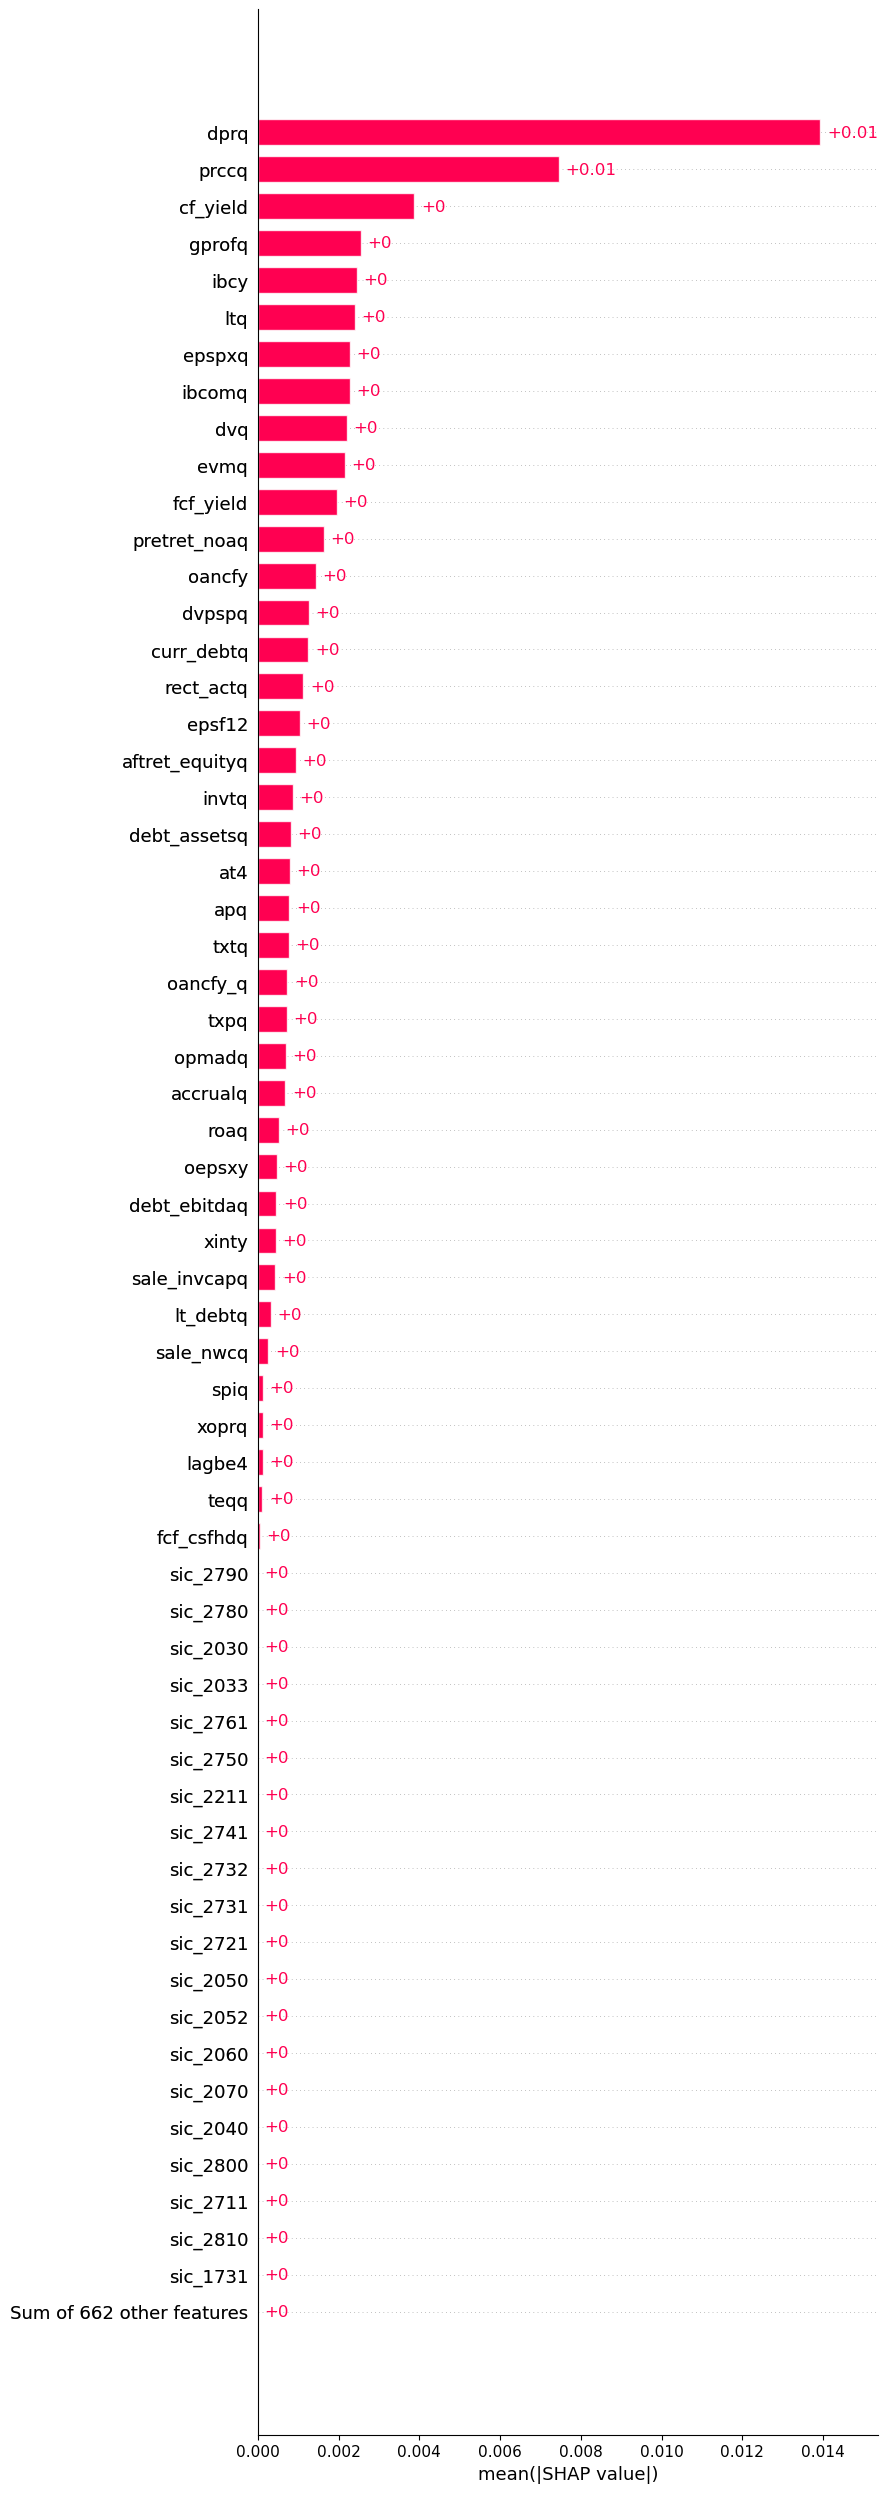

In [77]:
shap.plots.bar(shap_values[:,:-1],max_display=60,)

In [93]:
cols=valid_1_norm.columns[:-2]
shap_cols = cols[np.abs(shap_values[:,:-2].values).mean(axis=0)>0.000]

In [94]:
shap_cols

Index(['apq', 'epsf12', 'epspxq', 'ibcomq', 'invtq', 'ltq', 'spiq', 'teqq',
       'txpq', 'txtq', 'xoprq', 'ibcy', 'oancfy', 'oepsxy', 'xinty', 'dvpspq',
       'prccq', 'evmq', 'oancfy_q', 'cf_yield', 'dvq', 'dprq', 'opmadq', 'at4',
       'roaq', 'lagbe4', 'aftret_equityq', 'pretret_noaq', 'gprofq',
       'rect_actq', 'debt_ebitdaq', 'curr_debtq', 'lt_debtq', 'fcf_csfhdq',
       'fcf_yield', 'debt_assetsq', 'sale_invcapq', 'sale_nwcq', 'accrualq'],
      dtype='object')

In [95]:
len(shap_cols)

39

In [96]:
start_dates = [pd.to_datetime('2010-01-01') + pd.DateOffset(months = 3 * i) for i in range(21)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]
test_frames = [data.loc[d + pd.DateOffset(months=6):d+pd.DateOffset(months = 9)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]
valid_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in test_frames]

In [97]:
scalers = [StandardScaler() for _ in range(len(training_data))]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(training_data))]
opt_valid_data = [pd.DataFrame(scalers[i].transform(valid_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(valid_data))]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(test_data))]

In [98]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        t_clf.fit(opt_training_data[i],training_labels[i])

        preds = t_clf.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)



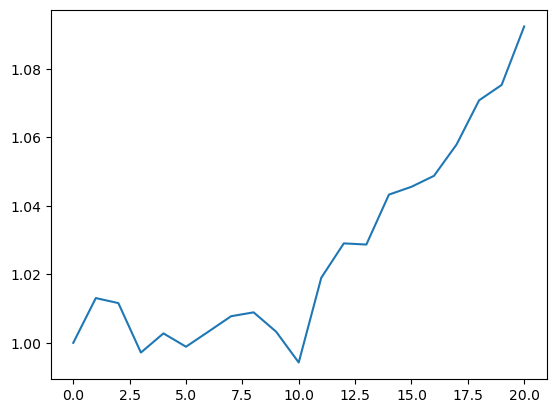

In [99]:
plt.plot(x);

In [100]:
SPY = pd.read_pickle(r'/Users/qigege/Desktop/33160 Machine Learning in Finance/Assignment/Assignment2/SPY_cum_ret.pkl')
SPY = SPY.loc['2013-07-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0]+1)
SPY['strategy'] = x

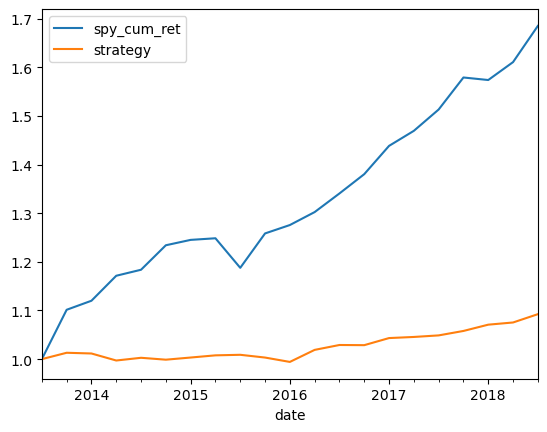

In [101]:
SPY.plot();

In [102]:
SPY = SPY.resample('Y').ffill()

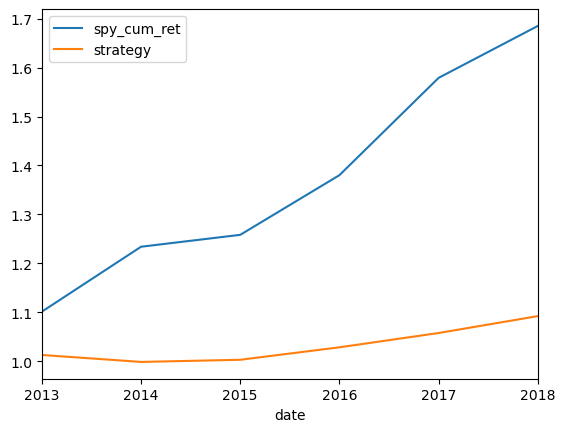

In [103]:
SPY.plot();

In [104]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.7802968318807558


In [105]:
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_std

0.020338046426088333

In [150]:
(SPY['spy_cum_ret'] - 1).diff().mean()
(SPY['spy_cum_ret'] - 1).diff().std()
print('SPY Sharpe Ratio: ',(SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std())

SPY Sharpe Ratio:  1.865328741562657


In [151]:
print('Strategy Cumulative Return: ',x[-1])
print('SPY Cumulative Return: ',SPY['spy_cum_ret'][-1])

Strategy Cumulative Return:  1.0924280784576617
SPY Cumulative Return:  1.6850179999999995


In [109]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

0.12194069805701135

In [110]:
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
IR

0.09408983315834299

In [111]:
alpha = np.mean(residual_ret)
alpha

0.0016377216650113407

## Question 2

In [112]:
t_clf2 = DecisionTreeClassifier(max_depth=6,min_samples_leaf=200)

In [114]:
bg_clf2 = BaggingClassifier(t_clf2,n_estimators=40,random_state=123,n_jobs=-1)

In [116]:
bg_clf2.fit(train_norm,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=6,
                                                        min_samples_leaf=200),
                  n_estimators=40, n_jobs=-1, random_state=123)

In [117]:
def objective2(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    t_min_samples_leaf = trial.suggest_int('min_samples_leaf',100,1200,step=100)
    t_max_depth = trial.suggest_int('max_depth',5,25,step=5)
    t_n_estimators = trial.suggest_int('n_estimators',5,50,step=5)

    
    t_clf2 = DecisionTreeClassifier(min_samples_leaf = t_min_samples_leaf,max_depth=t_max_depth,random_state=123)
    bg_clf2 = BaggingClassifier(t_clf1,n_estimators=t_n_estimators,random_state=123,n_jobs=1)
    bg_clf2.fit(train,labels)

    preds = bg_clf2.predict(val)
    conviction = bg_clf2.predict_proba(val)[:,2]-bg_clf2.predict_proba(val)[:,0]  # p(+1)-p(-1)
    weight = conviction / abs(conviction).sum()
    profit = (weight * val_rets).sum()

#     score = bg_clf.score(val,val_labels)

    return profit

In [118]:
study2 = optuna.create_study(direction="maximize")

[I 2023-01-29 03:43:52,445] A new study created in memory with name: no-name-7fbfaa05-7a45-4bc3-96de-be04355777ee


In [122]:
%%time
study2.optimize(partial(objective,train=train_norm,labels=y_train,val=valid_norm,val_labels=y_valid,val_rets=valid_stock_returns.values), n_trials=200,n_jobs=-1)

[I 2023-01-29 03:45:30,434] Trial 8 finished with value: -38.40251300000005 and parameters: {'min_samples_leaf': 900, 'max_depth': 15, 'n_estimators': 5}. Best is trial 8 with value: -38.40251300000005.
[I 2023-01-29 03:45:34,775] Trial 14 finished with value: -40.36775700000003 and parameters: {'min_samples_leaf': 1000, 'max_depth': 25, 'n_estimators': 10}. Best is trial 8 with value: -38.40251300000005.
[I 2023-01-29 03:45:38,017] Trial 13 finished with value: -38.48808100000003 and parameters: {'min_samples_leaf': 500, 'max_depth': 5, 'n_estimators': 10}. Best is trial 8 with value: -38.40251300000005.
[I 2023-01-29 03:45:40,020] Trial 15 finished with value: -37.264815000000034 and parameters: {'min_samples_leaf': 800, 'max_depth': 20, 'n_estimators': 15}. Best is trial 15 with value: -37.264815000000034.
[I 2023-01-29 03:45:42,121] Trial 17 finished with value: -30.66219800000004 and parameters: {'min_samples_leaf': 300, 'max_depth': 25, 'n_estimators': 5}. Best is trial 17 with v

[I 2023-01-29 03:49:15,400] Trial 46 finished with value: -33.58218800000004 and parameters: {'min_samples_leaf': 200, 'max_depth': 15, 'n_estimators': 45}. Best is trial 30 with value: -28.77521400000004.
[I 2023-01-29 03:49:16,122] Trial 47 finished with value: -33.58218800000004 and parameters: {'min_samples_leaf': 200, 'max_depth': 15, 'n_estimators': 45}. Best is trial 30 with value: -28.77521400000004.
[I 2023-01-29 03:49:18,365] Trial 48 finished with value: -33.58218800000004 and parameters: {'min_samples_leaf': 200, 'max_depth': 15, 'n_estimators': 45}. Best is trial 30 with value: -28.77521400000004.
[I 2023-01-29 03:49:24,219] Trial 49 finished with value: -33.58218800000004 and parameters: {'min_samples_leaf': 200, 'max_depth': 15, 'n_estimators': 45}. Best is trial 30 with value: -28.77521400000004.
[I 2023-01-29 03:49:34,035] Trial 55 finished with value: -36.34591200000003 and parameters: {'min_samples_leaf': 400, 'max_depth': 15, 'n_estimators': 15}. Best is trial 30 wi

[I 2023-01-29 03:51:34,185] Trial 87 finished with value: -26.944043000000054 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 5}. Best is trial 79 with value: -26.944043000000054.
[I 2023-01-29 03:51:35,732] Trial 76 finished with value: -29.70734200000005 and parameters: {'min_samples_leaf': 100, 'max_depth': 10, 'n_estimators': 30}. Best is trial 79 with value: -26.944043000000054.
[I 2023-01-29 03:51:36,684] Trial 88 finished with value: -26.944043000000054 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 5}. Best is trial 79 with value: -26.944043000000054.
[I 2023-01-29 03:51:37,949] Trial 77 finished with value: -29.56871000000004 and parameters: {'min_samples_leaf': 100, 'max_depth': 10, 'n_estimators': 25}. Best is trial 79 with value: -26.944043000000054.
[I 2023-01-29 03:51:39,164] Trial 78 finished with value: -29.56871000000004 and parameters: {'min_samples_leaf': 100, 'max_depth': 10, 'n_estimators': 25}. Best is trial 7

[I 2023-01-29 03:52:44,395] Trial 119 finished with value: -27.459071000000044 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 15}. Best is trial 107 with value: -26.843109000000055.
[I 2023-01-29 03:52:45,818] Trial 120 finished with value: -27.459071000000044 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 15}. Best is trial 107 with value: -26.843109000000055.
[I 2023-01-29 03:52:50,356] Trial 128 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 10}. Best is trial 107 with value: -26.843109000000055.
[I 2023-01-29 03:52:53,711] Trial 123 finished with value: -27.459071000000044 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 15}. Best is trial 107 with value: -26.843109000000055.
[I 2023-01-29 03:52:53,978] Trial 125 finished with value: -27.459071000000044 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 15}. B

[I 2023-01-29 03:54:05,514] Trial 159 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 10}. Best is trial 107 with value: -26.843109000000055.
[I 2023-01-29 03:54:06,144] Trial 160 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 10}. Best is trial 107 with value: -26.843109000000055.
[I 2023-01-29 03:54:09,121] Trial 161 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 10}. Best is trial 107 with value: -26.843109000000055.
[I 2023-01-29 03:54:12,027] Trial 162 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 10}. Best is trial 107 with value: -26.843109000000055.
[I 2023-01-29 03:54:13,489] Trial 163 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 10}. B

[I 2023-01-29 03:55:35,310] Trial 196 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 15, 'n_estimators': 10}. Best is trial 107 with value: -26.843109000000055.
[I 2023-01-29 03:55:38,642] Trial 197 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 15, 'n_estimators': 10}. Best is trial 107 with value: -26.843109000000055.
[I 2023-01-29 03:55:42,491] Trial 198 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 15, 'n_estimators': 10}. Best is trial 107 with value: -26.843109000000055.
[I 2023-01-29 03:55:45,224] Trial 199 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 15, 'n_estimators': 10}. Best is trial 107 with value: -26.843109000000055.
[I 2023-01-29 03:55:46,144] Trial 200 finished with value: -26.843109000000055 and parameters: {'min_samples_leaf': 100, 'max_depth': 15, 'n_estimators': 10}. B

CPU times: user 1h 2min 33s, sys: 4min 3s, total: 1h 6min 37s
Wall time: 10min 31s


In [123]:
study2.best_params

{'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 10}

In [124]:
t_clf2 = DecisionTreeClassifier(**{'min_samples_leaf': 500, 'max_depth': 5},random_state=123)
bg_clf2 = BaggingClassifier(t_clf2,n_estimators=5,random_state=123)

In [125]:
bg_clf2.fit(train_norm,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                        min_samples_leaf=500,
                                                        random_state=123),
                  n_estimators=5, random_state=123)

In [126]:
pred_valid2 = bg_clf2.predict(valid_norm)

In [127]:
bg_clf2.score(train_norm,y_train)

0.45750497017892644

In [128]:
bg_clf2.score(valid_norm,y_valid)

0.3816793893129771

In [129]:
confusion_matrix(pred_valid2,y_valid)

array([[  0,   0,   0],
       [ 56, 226, 222],
       [221, 392, 324]])

In [130]:
(pred_valid2 * df_valid['next_period_return'].values).sum()

-37.86556300000003

In [131]:
fi2 = bagging_feat_importance(bg_clf2,train_norm)

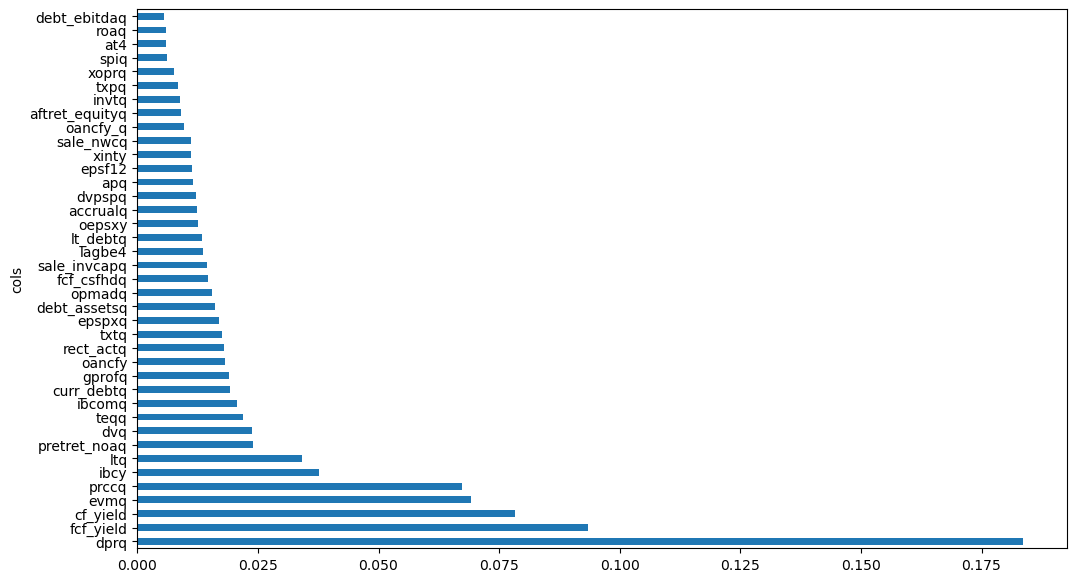

In [132]:
features2 = fi2[(fi2['feat_imp'] > 0.0)]
plot_fi(features2);

In [133]:
features2

,cols,feat_imp
108,dprq,0.183588
156,fcf_yield,0.093496
105,cf_yield,0.078295
95,evmq,0.069242
87,prccq,0.067216
74,ibcy,0.037613
32,ltq,0.034192
134,pretret_noaq,0.023975
107,dvq,0.023843
55,teqq,0.021879


In [134]:
cols2 = features2['cols'].values

In [135]:
float_vars2 = [x for x in train[cols2].columns if data[x].dtype == 'float64']

In [136]:
len(float_vars2)

39

In [137]:
train_red_norm2 = train.copy()
valid_red_norm2 = valid.copy()
test_red_norm2 = test.copy()

In [138]:
(train[cols2])[float_vars2]

,dprq,fcf_yield,cf_yield,evmq,prccq,ibcy,ltq,pretret_noaq,dvq,teqq,...,sale_nwcq,oancfy_q,aftret_equityq,invtq,txpq,xoprq,spiq,at4,roaq,debt_ebitdaq
0,-0.000000,-0.240149,-0.169552,9.984334,3.74,-144.387,3591.867,0.102661,0.000,0.000,...,7.555777,-120.619,-0.061574,1318.400,55.262,2658.964,-33.038,5978.78375,0.058779,4.372246
1,0.000000,0.011254,0.066042,10.416394,23.47,15.286,651.828,0.375016,0.000,0.000,...,-36.888873,28.833,0.210997,0.000,13.259,128.609,-1.258,632.20750,0.327732,1.340522
2,0.504083,0.032183,0.058744,14.419331,34.94,14.486,183.092,0.206978,7.635,0.000,...,1.517032,27.926,0.116786,106.226,9.142,93.769,-0.020,670.32350,0.174299,0.526466
3,0.232950,0.064275,0.078493,11.053903,52.67,33.567,860.079,0.389329,6.483,0.000,...,5.991515,37.454,0.210587,211.886,0.000,416.243,0.000,1416.55675,0.174187,1.505447
4,0.294118,0.041148,0.056404,16.877680,48.07,90.000,5479.000,0.221012,54.000,0.000,...,2.739503,600.000,0.116615,1954.000,188.000,1289.000,-10.000,11895.00000,0.144604,1.075547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16091,0.387001,0.123504,0.149640,8.147823,28.09,111.160,1390.263,0.243162,0.000,2496.085,...,3.614412,149.281,0.079279,495.934,0.000,736.718,-4.052,3776.45325,0.163183,1.286551
16092,-0.000000,0.118667,0.155875,4.322568,7.52,202.000,4635.000,-0.055842,0.000,7091.000,...,6.565015,326.000,-0.196149,1037.000,40.000,1060.000,57.000,11592.75000,0.125948,2.151846
16093,0.000000,0.040478,0.045822,32.111496,26.70,63.865,748.629,0.218236,0.000,1107.200,...,1.686988,54.150,0.072975,0.000,0.000,154.209,-8.750,1792.09000,0.080279,0.000000
16094,0.000000,0.074420,0.078065,10.179195,8.60,62.520,368.858,0.289583,0.000,796.749,...,2.941440,30.110,0.082152,0.000,8.909,139.736,0.000,1111.00200,0.120321,0.329656


In [139]:
train_red_norm[float_vars2] = scaler.fit_transform((train[cols2])[float_vars2])
valid_red_norm[float_vars2] = scaler.transform((valid[cols2])[float_vars2])
test_red_norm[float_vars2] = scaler.transform((test[cols2])[float_vars2])

In [140]:
bg_clf2.fit(train_red_norm2,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                        min_samples_leaf=500,
                                                        random_state=123),
                  n_estimators=5, random_state=123)

In [141]:
valid_2_norm = valid_red_norm2.copy()

valid_2_norm['rets'] = df_valid['next_period_return'].values

In [142]:
pred2 = bg_clf2.predict(valid_red_norm2)

In [143]:
(pred2*valid_2_norm[valid_2_norm.columns[-1]].values).sum()

-37.86556300000003

In [147]:


def model2(features2):
    
    tree_features2 = features2[features2.columns[:-1].values]
    conviction = bg_clf2.predict_proba(tree_features2)[:,2] - bg_clf2.predict_proba(tree_features2)[:,0]
    weight = conviction / abs(conviction).sum()
    ret = weight * features2[features2.columns[-1]]

    return ret

In [148]:
explainer2 = shap.explainers.Permutation(model2,valid_2_norm,)

In [152]:
shap_values2 = explainer2(valid_2_norm,max_evals=2000,)

Permutation explainer: 1442it [2:17:51,  5.74s/it]                                                                              


In [153]:
shap_values2.values.shape

(1441, 722)

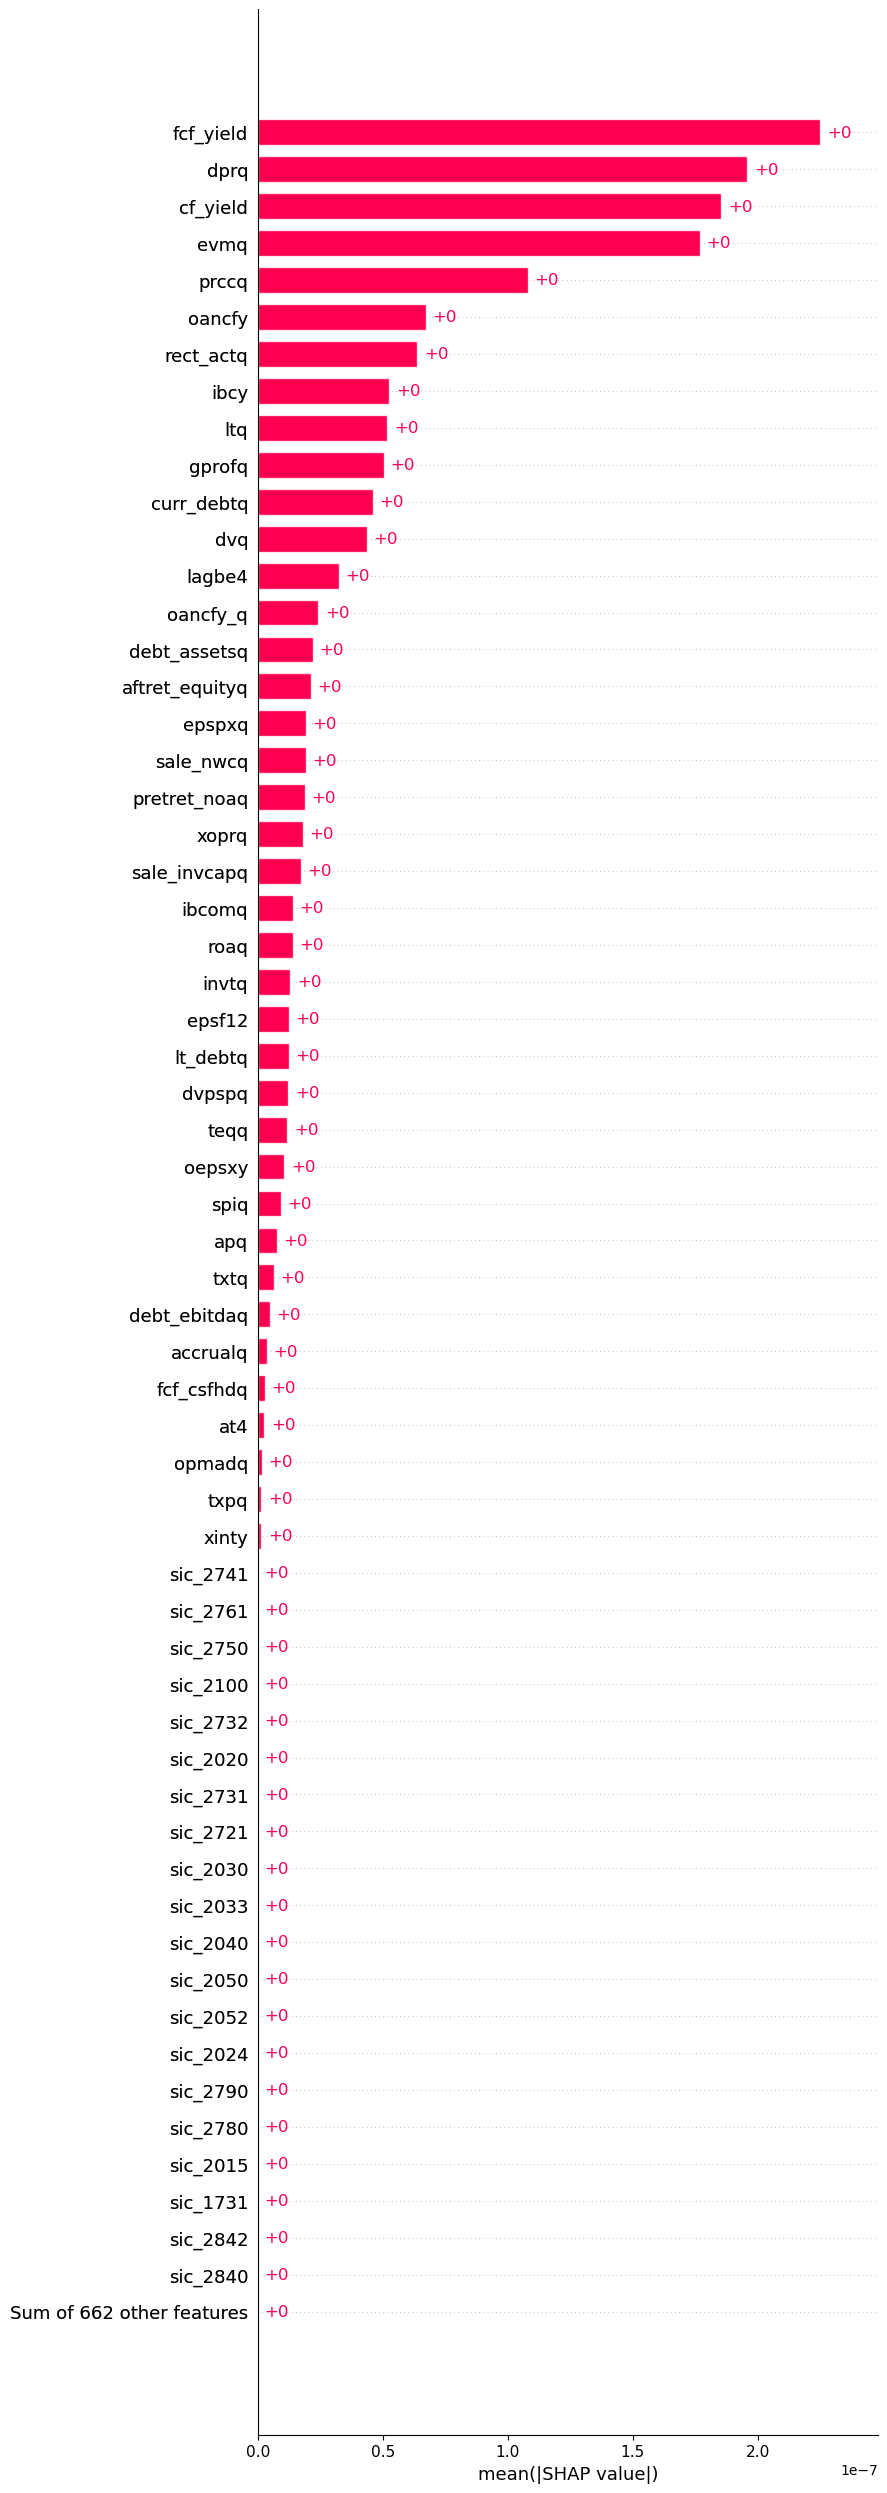

In [154]:
shap.plots.bar(shap_values2[:,:-1],max_display=60,)

In [158]:
cols2=valid_2_norm.columns[:-1]
shap_cols2 = cols2[np.abs(shap_values2[:,:-1].values).mean(axis=0)>0.000]

In [159]:
scalers = [StandardScaler() for _ in range(len(training_data))]
           
opt_training_data2 = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_cols2].values),columns=shap_cols2) for i in range(len(training_data))]
opt_valid_data2 = [pd.DataFrame(scalers[i].transform(valid_frames[i][shap_cols2].values),columns=shap_cols2) for i in range(len(valid_data))]
opt_test_data2 = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_cols2].values),columns=shap_cols2) for i in range(len(test_data))]

In [160]:
x2 = [1]
ret2 = []

for i in range(len(start_dates)-1):
        bg_clf2.fit(opt_training_data2[i],training_labels[i])

        preds = bg_clf2.predict(opt_test_data2[i])
        conviction = bg_clf2.predict_proba(opt_test_data2[i])[:,2]-bg_clf2.predict_proba(opt_test_data2[i])[:,0]
        weight = conviction / abs(conviction).sum()
        profit_i = (weight*test_frames[i]['next_period_return']).sum()
        ret2.append(profit_i)
        #num_names = len(opt_test_data2[i])
        
        x2.append(x2[i] + (x2[i])*profit_i)

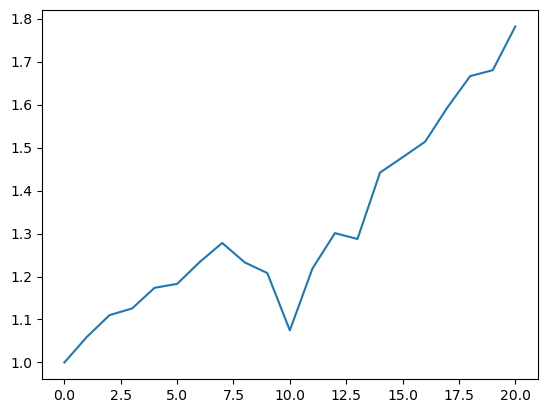

In [161]:
plt.plot(x2)

In [162]:
SPY = pd.read_pickle(r'/Users/qigege/Desktop/33160 Machine Learning in Finance/Assignment/Assignment2/SPY_cum_ret.pkl')
SPY = SPY.loc['2013-07-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0]+1)
SPY['strategy2'] = x2

<AxesSubplot:xlabel='date'>

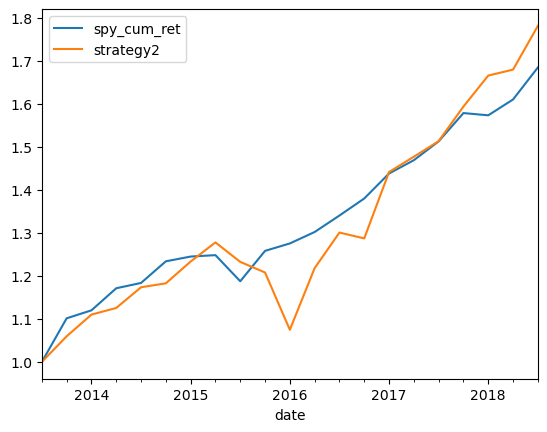

In [163]:
SPY.plot()

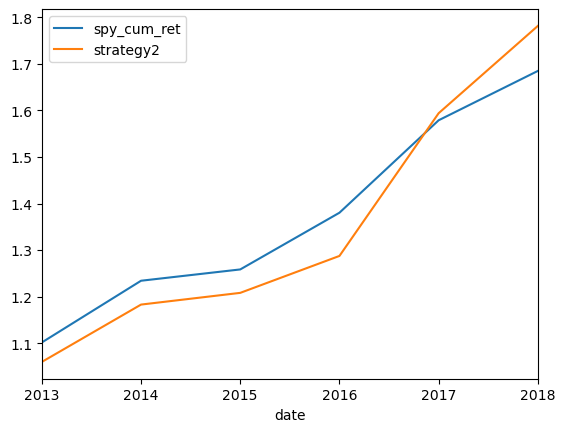

In [164]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

In [165]:
strategy_mean_ret2 = (SPY['strategy2'] - 1).diff().mean()
strategy_std2 = (SPY['strategy2'] - 1).diff().std()
strategy_sr2 = strategy_mean_ret2/strategy_std2
print('Strategy Sharpe Ratio: ',strategy_sr2)

Strategy Sharpe Ratio:  1.330744516702028


In [166]:
strategy_std2 = (SPY['strategy2'] - 1).diff().std()
strategy_std2

0.10853615455206284

In [167]:
(SPY['spy_cum_ret'] - 1).diff().mean()
(SPY['spy_cum_ret'] - 1).diff().std()
print('SPY Sharpe Ratio: ',(SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std())

SPY Sharpe Ratio:  1.865328741562657


In [168]:
print('Strategy Cumulative Return: ',x2[-1])
print('SPY Cumulative Return: ',SPY['spy_cum_ret'][-1])

Strategy Cumulative Return:  1.7817776986133307
SPY Cumulative Return:  1.6850179999999995


In [169]:
strategy_ret2 = (SPY['strategy2'] - 1).diff().values[1:]
spy_ret2 = (SPY['spy_cum_ret'] - 1).diff().values[1:]

beta2 = (np.cov(spy_ret2,strategy_ret2)/np.var(spy_ret2))[1,0]
beta2

1.8517002727017446

In [170]:
residual_ret2 = strategy_ret2 - beta2 * spy_ret2
IR2 = np.mean(residual_ret2)/np.std(residual_ret2)
IR2

-1.3129421970430724

In [171]:
alpha2 = np.mean(residual_ret2)
alpha2

-0.07168249037359335